In [ ]:
## ***
## NOTE: modify common/torch/ops.py for your gpu
## ***

## versions:
## Python    : 3.11.5
## numpy     : 1.26.0
## torch     : 2.1.0
## pandas    : 2.1.1

# licensed under the Creative Commons - Attribution-NonCommercial 4.0
# International license (CC BY-NC 4.0):
# https://creativecommons.org/licenses/by-nc/4.0/. 

In [1]:
import numpy as np
import pandas as pd
import torch as t
import matplotlib.pyplot as plt
import os

import seaborn as sns
import warnings
from matplotlib.dates import DateFormatter
sns.set_theme(context='paper', style="ticks", font_scale=1.0)
warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
dates = ["2023-01-02"]
t = pd.to_datetime("2023-01-02")
for i in range(51):
    t = t + pd.Timedelta(days=7)
    dates.append(t.strftime("%Y-%m-%d"))
dates.remove("2023-06-19")

locs = ['01', '02', '04', '05', '06', '08', '09', '10', '11', '12', '13',
       '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25',
       '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '44', '45', '46', '47', '48',
       '49', '50', '51', '53', '54', '55', '56', '72', 'US']

In [2]:
'''
f = "https://media.githubusercontent.com/media/reichlab/covid19-forecast-hub/master/data-truth/truth-Incident%20Hospitalizations.csv"
dft_all = pd.read_csv(f,dtype={"location":str})
dft_all["date"] = pd.to_datetime(dft_all["date"])
dft_all.to_csv("truth-Incident Hospitalizations.csv",index=False)

for d in dates:
    f = "https://github.com/reichlab/covid19-forecast-hub/raw/master/data-processed/COVIDhub-4_week_ensemble/"+d+"-COVIDhub-4_week_ensemble.csv"
    dfe = pd.read_csv(f,dtype={"location":str})
    dfe = dfe.query("quantile == 0.5")
    dfe = dfe.loc[dfe["target"].str.contains("inc hosp")]
    dfe.to_csv("COVIDhub-4_week_ensemble/"+d+"-COVIDhub-4_week_ensemble.csv",index=False)

for d in dates:
    f = "https://github.com/reichlab/covid19-forecast-hub/raw/master/data-processed/COVIDhub-trained_ensemble/"+d+"-COVIDhub-trained_ensemble.csv"
    dfe = pd.read_csv(f,dtype={"location":str})
    dfe = dfe.query("quantile == 0.5")
    dfe = dfe.loc[dfe["target"].str.contains("inc hosp")]
    dfe.to_csv("COVIDhub-trained_ensemble/"+d+"-COVIDhub-trained_ensemble.csv",index=False)
'''

In [3]:
dft_all = pd.read_csv("storage/truth-inc-hosp-2024-04.csv", dtype={"location":str})
dft_all["date"] = pd.to_datetime(dft_all["date"])

In [4]:
dfs = []
for d in dates:
    f = d + "-OHT_JHU-nbxd.csv"
    dfr = pd.read_csv("results2023/"+f,dtype={"location":str}).query("quantile == 0.5")
    dfr["date"] = pd.to_datetime(dfr["target_end_date"])
    dfr["forecast_on"] = pd.to_datetime(dfr["forecast_date"])
    dfr["horizon"] = (dfr["date"] - dfr["forecast_on"]).dt.days
    dfr = dfr.query("horizon > 0 and horizon < 29")
    df = pd.merge(dfr[["forecast_on","location","date","horizon","value"]], dft_all[["location","date","value"]],
                  on=["location","date"], suffixes=["_pred","_true"])
    df["AE"] = (df["value_pred"] - df["value_true"]).map(np.abs)
    df["APE"] = df["AE"] / df["value_true"]
    df["sAPE"] = 200.0 * df["AE"] / (df["value_pred"].map(np.abs) + df["value_true"].map(np.abs))
    dfs.append(df)


In [5]:
dfs_4wk = []
for d in dates:
    f = "COVIDhub-4_week_ensemble/"+d+"-COVIDhub-4_week_ensemble.csv"
    dfr = pd.read_csv(f,dtype={"location":str})
    dfr["date"] = pd.to_datetime(dfr["target_end_date"])
    dfr["forecast_on"] = pd.to_datetime(dfr["forecast_date"])
    dfr["horizon"] = (dfr["date"] - dfr["forecast_on"]).dt.days
    dfr = dfr.query("horizon > 0 and horizon < 29")
    df = pd.merge(dfr[["forecast_on","location","date","horizon","value"]], dft_all[["location","date","value"]],
                  on=["location","date"], suffixes=["_pred","_true"])
    df["AE"] = (df["value_pred"] - df["value_true"]).map(np.abs)
    df["APE"] = df["AE"] / df["value_true"]
    df["sAPE"] = 200.0 * df["AE"] / (df["value_pred"].map(np.abs) + df["value_true"].map(np.abs))
    dfs_4wk.append(df)


In [6]:
dfs_tr = []
for d in dates:
    f = "COVIDhub-trained_ensemble/"+d+"-COVIDhub-trained_ensemble.csv"
    dfr = pd.read_csv(f,dtype={"location":str})
    dfr["date"] = pd.to_datetime(dfr["target_end_date"])
    dfr["forecast_on"] = pd.to_datetime(dfr["forecast_date"])
    dfr["horizon"] = (dfr["date"] - dfr["forecast_on"]).dt.days
    dfr = dfr.query("horizon > 0 and horizon < 29")
    df = pd.merge(dfr[["forecast_on","location","date","horizon","value"]], dft_all[["location","date","value"]],
                  on=["location","date"], suffixes=["_pred","_true"])
    df["AE"] = (df["value_pred"] - df["value_true"]).map(np.abs)
    df["APE"] = df["AE"] / df["value_true"]
    df["sAPE"] = 200.0 * df["AE"] / (df["value_pred"].map(np.abs) + df["value_true"].map(np.abs))
    dfs_tr.append(df)


In [7]:
nb_MAE = pd.concat(dfs).query("location == 'US'")["AE"].mean()
nb_MAPE = pd.concat(dfs).query("location == 'US'")["APE"].mean()
nb_sMAPE = pd.concat(dfs).query("location == 'US'")["sAPE"].mean()

nb_MAE, nb_MAPE, nb_sMAPE


(438.0277100840337, 0.16450047484835917, 16.65340128535159)

In [8]:
e4_MAE = pd.concat(dfs_4wk).query("location == 'US'")["AE"].mean()
e4_MAPE = pd.concat(dfs_4wk).query("location == 'US'")["APE"].mean()
e4_sMAPE = pd.concat(dfs_4wk).query("location == 'US'")["sAPE"].mean()

e4_MAE, e4_MAPE, e4_sMAPE

(612.84243697479, 0.24536960052094614, 23.645321286772393)

In [9]:
t4_MAE = pd.concat(dfs_tr).query("location == 'US'")["AE"].mean()
t4_MAPE = pd.concat(dfs_tr).query("location == 'US'")["APE"].mean()
t4_sMAPE = pd.concat(dfs_tr).query("location == 'US'")["sAPE"].mean()

t4_MAE, t4_MAPE, t4_sMAPE

(585.2920168067227, 0.22598538176632949, 22.323256383082295)

In [3]:
(438.0277100840337 - 612.84243697479) / 612.84243697479, (438.0277100840337 - 585.2920168067227)/ 585.2920168067227

(-0.2852523199171788, -0.2516082613361856)

In [10]:
df_comp = pd.merge(
    pd.concat(dfs), pd.concat(dfs_tr), on=["forecast_on","location","date"],
    suffixes=["_nb","_tr"]
)
df_comp["horizon"] = (df_comp["date"] - df_comp["forecast_on"]).dt.days

In [11]:
## us, by date

us_comp = df_comp.query("location == 'US'")

In [12]:
us_comp_fdate = us_comp[["forecast_on","APE_nb","APE_tr","sAPE_nb","sAPE_tr"]].groupby("forecast_on").agg("mean")

<Axes: xlabel='forecast_on'>

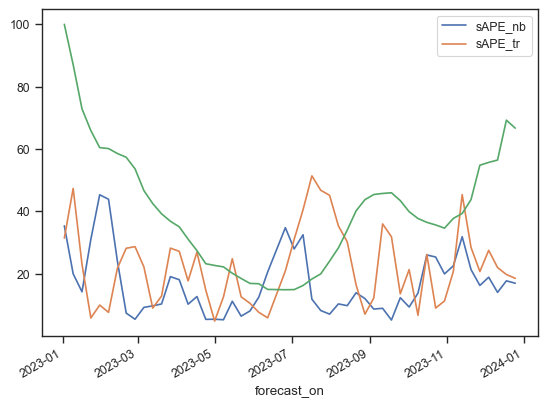

In [13]:
ax = us_comp_fdate[["sAPE_nb","sAPE_tr"]].plot()
dft_us_on_fdate = dft_all.query("location == 'US'").set_index("date").loc[us_comp_fdate.index,["value"]]
(100.0 * dft_us_on_fdate["value"] / np.max(dft_us_on_fdate["value"])).plot()


In [14]:
## us, by horizon

us_comp_horizon = us_comp[["horizon","sAPE_nb","sAPE_tr"]].groupby("horizon").agg("mean")


In [15]:
%config InlineBackend.figure_formats = ["svg"]
plt.style.use("default")
sns.set_theme(context='paper', style="ticks", font_scale=1.25)


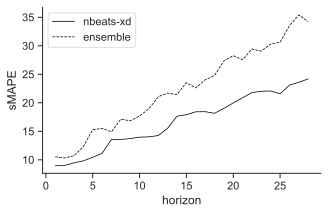

In [16]:
fig, ax = plt.subplots(1,1,figsize=[5,3],dpi=300)
ax.plot(us_comp_horizon["sAPE_nb"], label="nbeats-xd", linestyle="solid", color="black", linewidth=0.75);
ax.plot(us_comp_horizon["sAPE_tr"], label="ensemble", linestyle="dashed", color="black", linewidth=0.75);
ax.legend()
ax.set(xlabel="horizon", ylabel="sMAPE")
sns.despine()

plt.savefig("comp_us_horizon.png", bbox_inches='tight',dpi=300)


In [17]:
us_fdate_over_horizon = us_comp[["forecast_on","horizon","sAPE_nb","sAPE_tr"]].groupby(["forecast_on"]).agg(["mean","min","max"])

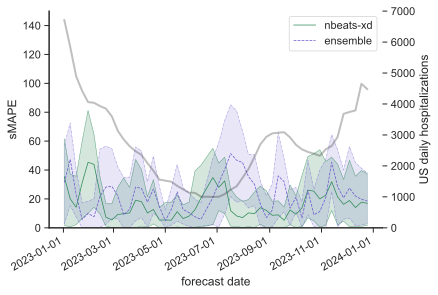

In [21]:
fig, ax = plt.subplots(1,1,figsize=[6,4],dpi=300)
colors = ["seagreen","slateblue"]
ax.plot(us_fdate_over_horizon.loc[:,("sAPE_nb","mean")], label="nbeats-xd", linestyle="solid", color=colors[0], linewidth=0.75);
ax.plot(us_fdate_over_horizon.loc[:,("sAPE_nb","max")], label="", linestyle="solid", color=colors[0], linewidth=0.25);
ax.plot(us_fdate_over_horizon.loc[:,("sAPE_nb","min")], label="", linestyle="solid", color=colors[0], linewidth=0.25);

ax.plot(us_fdate_over_horizon.loc[:,("sAPE_tr","mean")], label="ensemble", linestyle="dashed", color=colors[1], linewidth=0.75);
ax.plot(us_fdate_over_horizon.loc[:,("sAPE_tr","max")], label="", linestyle="dashed", dashes=(9,9), color=colors[1], linewidth=0.25);
ax.plot(us_fdate_over_horizon.loc[:,("sAPE_tr","min")], label="", linestyle="dashed", dashes=(9,9), color=colors[1], linewidth=0.25);

ax.fill_between(us_fdate_over_horizon.index, us_fdate_over_horizon.loc[:,("sAPE_nb","min")],us_fdate_over_horizon.loc[:,("sAPE_nb","max")],alpha=0.2,color=colors[0])
ax.fill_between(us_fdate_over_horizon.index, us_fdate_over_horizon.loc[:,("sAPE_tr","min")],us_fdate_over_horizon.loc[:,("sAPE_tr","max")],alpha=0.15,color=colors[1])

ax.set_xticks(ax.get_xticks());
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='right');

ax2 = ax.twinx()
ax2.plot(dft_us_on_fdate["value"], label="", linewidth=2.0, color="black", linestyle="solid", alpha=0.25)

fig.tight_layout()
ax.legend(loc="upper right")
#ax2.legend()
ax.set(xlabel="forecast date", ylabel="sMAPE", ylim=(0,150))
ax2.set(ylim=(0,7000), ylabel="US daily hospitalizations")
sns.despine()

plt.savefig("comp_us_fdate.png", bbox_inches='tight',dpi=300)


In [19]:
## change-rate categories

location = "US"
dft_smoo = dft_all.query("location == '"+str(location)+"'").set_index("date")[["value"]]
dft_smoo["val_unsmoo"] = dft_smoo["value"]
dft_smoo["value"] = dft_smoo["value"].rolling(28,center=True).mean()


In [20]:
dft_smoo["delta-1"] = dft_smoo["value"].diff(7)
dft_smoo["delta-2"] = dft_smoo["value"].diff(14)
dft_smoo["delta-4"] = dft_smoo["value"].diff(28)
dft_smoo["delta+1"] = -1.0*dft_smoo["value"].diff(-7)
dft_smoo["delta+2"] = -1.0*dft_smoo["value"].diff(-14)
dft_smoo["delta+4"] = -1.0*dft_smoo["value"].diff(-28)

In [21]:
dft_smoo["dp_dw"] = (dft_smoo["delta-1"] + dft_smoo["delta+1"]) / (2.0 * dft_smoo["value"])

In [22]:
eps = 0.01
past = "delta-4"
fut = "delta+4"
dft_smoo["peak"] = ((dft_smoo[past]/dft_smoo["value"]) > eps) & ((dft_smoo[fut]/dft_smoo["value"]) < -eps)
dft_smoo["vall"] = ((dft_smoo[past]/dft_smoo["value"]) < -eps) & ((dft_smoo[fut]/dft_smoo["value"]) > eps)
dft_smoo["reversal"] = dft_smoo["peak"] | dft_smoo["vall"]

In [23]:
eps = 0.05
dft_smoo["increasing"] = (dft_smoo["dp_dw"] > eps)
dft_smoo["decreasing"] = (dft_smoo["dp_dw"] < -eps)

In [24]:
data = dft_smoo.loc["2023-01-01":"2024-01-01"]
#data = dft_smoo.loc[us_comp_fdate.index]


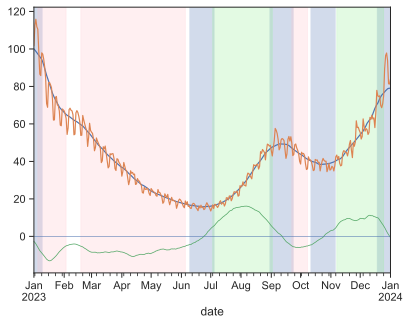

In [25]:
ax = (100.0 * data["value"] / np.max(data["value"])).plot()
(100.0 * data["val_unsmoo"] / np.max(data["value"])).plot()
(100.0 * data["dp_dw"]).plot(linewidth=0.75)
ax.fill_between(data.index, 0, 1, where=data["reversal"], alpha=0.25, transform=ax.get_xaxis_transform())
ax.fill_between(data.index, 0, 1, where=data["increasing"], alpha=0.25, color="lightgreen", transform=ax.get_xaxis_transform())
ax.fill_between(data.index, 0, 1, where=data["decreasing"], alpha=0.25, color="pink", transform=ax.get_xaxis_transform())
ax.hlines(0.0, data.index.min(), data.index.max(),linewidth=0.5)

In [26]:
us_comp_by_cat = pd.merge(us_comp,dft_smoo,left_on="forecast_on",right_index=True)

In [27]:
us_comp_by_cat[["reversal","sAPE_nb","sAPE_tr"]].groupby("reversal").agg("mean")

,sAPE_nb,sAPE_tr
reversal,,
False,15.110545,22.055877
True,20.730951,23.029902


In [28]:
us_comp_by_cat[["increasing","sAPE_nb","sAPE_tr"]].groupby("increasing").agg("mean")

,sAPE_nb,sAPE_tr
increasing,,
False,16.523499,18.625995
True,16.937563,30.411017


In [29]:
us_comp_by_cat[["decreasing","sAPE_nb","sAPE_tr"]].groupby("decreasing").agg("mean")

,sAPE_nb,sAPE_tr
decreasing,,
False,19.322656,25.113948
True,13.134838,18.644618


In [30]:
data_rev = us_comp_by_cat.loc[us_comp_by_cat["reversal"],["forecast_on","sAPE_nb","sAPE_tr"]].reset_index(drop=True).groupby(["forecast_on"]).agg("mean")
data_inc = us_comp_by_cat.loc[us_comp_by_cat["increasing"],["forecast_on","sAPE_nb","sAPE_tr"]].reset_index(drop=True).groupby(["forecast_on"]).agg("mean")
data_dec = us_comp_by_cat.loc[us_comp_by_cat["decreasing"],["forecast_on","sAPE_nb","sAPE_tr"]].reset_index(drop=True).groupby(["forecast_on"]).agg("mean")
data_all = us_comp_by_cat.loc[:,["forecast_on","sAPE_nb","sAPE_tr"]].reset_index(drop=True).groupby(["forecast_on"]).agg("mean")

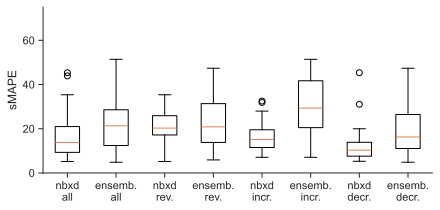

In [31]:
d = {
    "nb_all":data_all["sAPE_nb"].values,
    "tr_all":data_all["sAPE_tr"].values,
    "nb_rev":data_rev["sAPE_nb"].values,
    "tr_rev":data_rev["sAPE_tr"].values,
    "nb_inc":data_inc["sAPE_nb"].values,
    "tr_inc":data_inc["sAPE_tr"].values,
    "nb_dec":data_dec["sAPE_nb"].values,
    "tr_dec":data_dec["sAPE_tr"].values,
     }

fig, ax = plt.subplots(1,1,figsize=[7,3],dpi=300)
ax.boxplot(d.values(),
           labels=["nbxd\nall","ensemb.\nall",
                   "nbxd\nrev.","ensemb.\nrev.",
                   "nbxd\nincr.","ensemb.\nincr.",
                   "nbxd\ndecr.","ensemb.\ndecr.",]);
ax.set(ylabel="sMAPE", ylim=(0,75))
sns.despine()

plt.savefig("comp_us_categories.png", bbox_inches='tight',dpi=300)

In [32]:
#data_all["sAPE_nb"].describe()
us_fdate_over_horizon[("sAPE_nb","mean")].describe()

count    51.000000
mean     16.653401
std      10.060929
min       5.178325
25%       9.293260
50%      13.799831
75%      20.976317
max      45.341030
Name: (sAPE_nb, mean), dtype: float64

In [33]:
us_fdate_over_horizon[("sAPE_tr","mean")].describe()

count    51.000000
mean     22.323256
std      12.241692
min       4.848158
25%      12.415120
50%      21.347101
75%      28.583223
max      51.411017
Name: (sAPE_tr, mean), dtype: float64

In [ ]:
## direction by category (at set horizon)

In [52]:
us_comp_dir = us_comp_by_cat.query("horizon == 28").copy()
eps = 0.005
val_init = "val_unsmoo"

us_comp_dir["true_increase"] = ((us_comp_dir["value_true_nb"] - us_comp_dir[val_init]) / us_comp_dir[val_init]) > eps
us_comp_dir["true_decrease"] = ((us_comp_dir["value_true_nb"] - us_comp_dir[val_init]) / us_comp_dir[val_init]) < -eps

us_comp_dir["pred_increase_nb"] = ((us_comp_dir["value_pred_nb"] - us_comp_dir[val_init]) / us_comp_dir[val_init]) > eps
us_comp_dir["pred_decrease_nb"] = ((us_comp_dir["value_pred_nb"] - us_comp_dir[val_init]) / us_comp_dir[val_init]) < -eps

us_comp_dir["pred_increase_tr"] = ((us_comp_dir["value_pred_tr"] - us_comp_dir[val_init]) / us_comp_dir[val_init]) > eps
us_comp_dir["pred_decrease_tr"] = ((us_comp_dir["value_pred_tr"] - us_comp_dir[val_init]) / us_comp_dir[val_init]) < -eps

us_comp_dir["true_dir"] = 0
us_comp_dir.loc[us_comp_dir["true_increase"],"true_dir"] = 1
us_comp_dir.loc[us_comp_dir["true_decrease"],"true_dir"] = -1

us_comp_dir["pred_dir_nb"] = 0
us_comp_dir.loc[us_comp_dir["pred_increase_nb"],"pred_dir_nb"] = 1
us_comp_dir.loc[us_comp_dir["pred_decrease_nb"],"pred_dir_nb"] = -1

us_comp_dir["pred_dir_tr"] = 0
us_comp_dir.loc[us_comp_dir["pred_increase_tr"],"pred_dir_tr"] = 1
us_comp_dir.loc[us_comp_dir["pred_decrease_tr"],"pred_dir_tr"] = -1

us_comp_dir["correct_dir_nb"] = (us_comp_dir["pred_dir_nb"] == us_comp_dir["true_dir"])
us_comp_dir["correct_dir_tr"] = (us_comp_dir["pred_dir_tr"] == us_comp_dir["true_dir"])

In [53]:
us_comp_dir.shape

(51, 41)

In [54]:
us_comp_dir['correct_dir_nb'].mean(), us_comp_dir['correct_dir_tr'].mean()

(0.803921568627451, 0.37254901960784315)

In [55]:
us_comp_dir[['reversal','correct_dir_nb','correct_dir_tr']].groupby("reversal").agg(["mean","count"])

correct_dir_nb       correct_dir_tr      
                   mean count           mean count
reversal                                          
False          0.837838    37       0.405405    37
True           0.714286    14       0.285714    14

In [56]:
us_comp_dir[['reversal','true_dir','correct_dir_nb','correct_dir_tr']].groupby(["reversal","true_dir"]).agg(["mean","count"])

correct_dir_nb       correct_dir_tr      
                            mean count           mean count
reversal true_dir                                          
False    -1             0.958333    24       0.541667    24
          0             0.000000     1       1.000000     1
          1             0.666667    12       0.083333    12
True     -1             1.000000     7       0.428571     7
          1             0.428571     7       0.142857     7

In [57]:
us_comp_dir[['increasing','correct_dir_nb','correct_dir_tr']].groupby("increasing").agg(["mean","count"])

correct_dir_nb       correct_dir_tr      
                     mean count           mean count
increasing                                          
False            0.828571    35       0.457143    35
True             0.750000    16       0.187500    16

In [58]:
us_comp_dir[['decreasing','correct_dir_nb','correct_dir_tr']].groupby("decreasing").agg(["mean","count"])

correct_dir_nb       correct_dir_tr      
                     mean count           mean count
decreasing                                          
False            0.689655    29       0.241379    29
True             0.954545    22       0.545455    22

In [ ]:
us_comp_dir[['forecast_on',
       'val_unsmoo','value_true_nb','value_pred_nb','value_pred_tr','reversal',
       'increasing', 'decreasing','true_dir','pred_dir_nb','pred_dir_tr',
       'correct_dir_nb','correct_dir_tr']]

In [191]:
## by location

In [62]:
comp_by_loc = df_comp[["location","sAPE_nb","sAPE_tr"]].groupby("location").agg("mean")
#comp_by_loc

<Axes: >

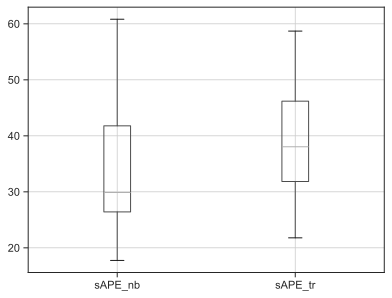

In [63]:
comp_by_loc.drop("US").boxplot()

In [64]:
st_pops = pd.read_csv("storage/PopulationEstimates.csv",dtype={"FIPStxt":str})
st_pops["pop"] = st_pops["POP_ESTIMATE_2023"].str.replace(",","").astype("Int64")
st_pops["st"] = st_pops["FIPStxt"].str.slice(0,2)
st_pops["cty"] = st_pops["FIPStxt"].str.slice(2,5)


In [65]:
comp_by_pop = st_pops.loc[st_pops["cty"]=="000",["st","pop"]].set_index("st").join(comp_by_loc)
comp_by_pop["logpop"] = comp_by_pop["pop"].apply(np.log).astype(float)
#comp_by_pop

In [66]:
comp_by_pop["sAPE_diff"] = comp_by_pop["sAPE_nb"] - comp_by_pop["sAPE_tr"]

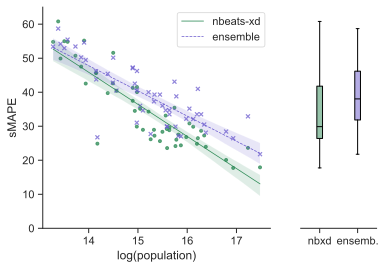

In [67]:

fig, ax = plt.subplots(1,2,figsize=[6,4],dpi=300, gridspec_kw={'width_ratios': [3, 1]})
colors = ["seagreen","slateblue"]

sns.regplot(ax=ax[0],data=comp_by_pop,x="logpop",y="sAPE_nb",color=colors[0],marker="o",line_kws={"linewidth":0.75,"label":"nbeats-xd"},scatter_kws={"alpha":0.75,"s":9})
sns.regplot(ax=ax[0],data=comp_by_pop,x="logpop",y="sAPE_tr",color=colors[1],marker="x",line_kws={"linewidth":0.75,"label":"ensemble","linestyle":"dashed"},scatter_kws={"alpha":0.75,"s":16})
ax[0].legend()
bp = ax[1].boxplot(comp_by_loc.drop("US"),labels=["nbxd","ensemb."],patch_artist=True);
ax[0].set(xlabel="log(population)",ylabel="sMAPE",ylim=(0,65))
ax[1].set(ylim=(0,65))

ax[1].yaxis.set_visible(False)
sns.despine(ax=ax[0])
sns.despine(ax=ax[1],top=True,left=True,right=True)

bp["boxes"][0].set(facecolor=(colors[0],0.5))
bp["boxes"][1].set(facecolor=(colors[1],0.5))
bp["medians"][0].set(color="black")
bp["medians"][1].set(color="black")

plt.savefig("comp_states.png", bbox_inches='tight',dpi=300)

In [68]:
from scipy import stats

In [69]:
stats.linregress(x=comp_by_pop["logpop"],y=comp_by_pop["sAPE_nb"])

LinregressResult(slope=-9.433204578504855, intercept=177.93415210694977, rvalue=-0.8844553311147916, pvalue=3.54573407057246e-18, stderr=0.7038274922494269, intercept_stderr=10.71546408697045)

In [70]:
stats.linregress(x=comp_by_pop["logpop"],y=comp_by_pop["sAPE_tr"])

LinregressResult(slope=-7.4044818904057825, intercept=151.46564908384602, rvalue=-0.8230398914870121, pvalue=7.042999143910465e-14, stderr=0.7226442671969032, intercept_stderr=11.001941211553746)

In [71]:
comp_by_loc.drop("US").describe()

,sAPE_nb,sAPE_tr
count,52.000000,52.000000
mean,34.642032,38.990201
std,11.012011,9.288746
min,17.745187,21.779995
25%,26.411332,31.845684
50%,29.877760,38.043578
75%,41.786327,46.180966
max,60.814072,58.701211


In [73]:
np.power(-0.8844553311147916, 2), np.power(-0.8230398914870121 ,2)

(0.7822612327373756, 0.6773946629789526)

In [74]:
(612 - 585) / 612, (612 - 438) / 612, (585 - 438) / 585

(0.04411764705882353, 0.28431372549019607, 0.2512820512820513)

In [79]:
nb_apes = np.array([df["sAPE"].mean() for df in dfs])

In [80]:
[np.percentile(nb_apes,x) for x in [0,25,50,75,100]]

[23.265160235919577,
 27.787387405939185,
 32.43390679219044,
 38.26043179409635,
 54.57529315646154]

In [81]:
tr_apes = np.array([df["sAPE"].mean() for df in dfs_tr])

In [82]:
[np.percentile(tr_apes,x) for x in [0,25,50,75,100]]

[25.744896407290295,
 32.86345542482865,
 37.75297715149804,
 43.90690192028511,
 68.17670705523884]

In [116]:
true2023 = dft_all.query("location == 'US'").iloc[888:1284][["date","value"]]
true2023["date"] = pd.to_datetime(true2023["date"])

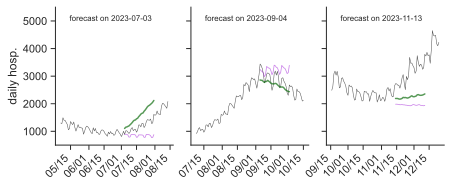

In [138]:
#i = 44 #34 #25
#print(dates[i])

fig,ax = plt.subplots(1,3,figsize=[7,2.5],dpi=300)

for (ax_id, i) in enumerate([25,34,44]):
    df = us_comp.loc[us_comp.forecast_on==dates[i],["date","value_pred_nb","value_pred_tr"]]
    df["date"] = pd.to_datetime(df["date"])

    sns.lineplot(ax=ax[ax_id],data=true2023.iloc[-50+(7*i):50+(7*i)],x="date",y="value",color="0.3",linewidth=0.5);
    sns.lineplot(ax=ax[ax_id],data=df,x="date",y="value_pred_nb",color="darkgreen",alpha=0.66,linewidth=1.5);
    sns.lineplot(ax=ax[ax_id],data=df,x="date",y="value_pred_tr",color="darkviolet",alpha=0.5,linewidth=0.75);
    sns.despine();
    fig.subplots_adjust(wspace=0.15)
    ax[ax_id].text(pd.to_datetime(dates[i])-pd.Timedelta(days=50),5000,"forecast on "+str(dates[i]),fontsize=8)

for (ax_id,x) in enumerate(ax):
    x.set_xticks(x.get_xticks());
    x.set_xticklabels(x.get_xticklabels(), rotation=45, horizontalalignment='right');
    x.xaxis.set_major_formatter(DateFormatter("%m/%d"))
    x.set(ylim=(500,5500),xlabel=None,ylabel=None)
    if ax_id > 0: 
        x.set_yticklabels("")
    else:
        x.set(ylabel="daily hosp.")

plt.savefig("examples.png",bbox_inches='tight',dpi=300)
